# Import for building essentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import shutil
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report
import torch
from imblearn.over_sampling import SMOTE
import zipfile
import os
from PIL import Image
import random
import pandas as pd
import numpy as np

# Download shared data dir at Drive

In [ ]:
!rm -rf /content/data

In [ ]:
!rm -rf /content/data/TODO

## Load data split

In [ ]:
!cp -r /content/drive/MyDrive/validation /content/data

In [ ]:
testdir = "/content/drive/MyDrive/validation"
test_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

test_data = DatasetImageCustom(testdir,transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

## End load data splited

In [ ]:
def descomprimir_archivo(ruta_archivo_zip, ruta_destino):
    with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
        zip_ref.extractall(ruta_destino)


ruta_archivo_zip = "/content/drive/MyDrive/MulticlassDiscriminatorImagesV2.zip"
ruta_destino = "/content/data"

if not os.path.exists(ruta_destino):
    os.makedirs(ruta_destino)

descomprimir_archivo(ruta_archivo_zip, ruta_destino)

In [ ]:
data_dir = "/content/data"
classes=["CURVATURA","INCLINACION", "ORIGINAL", "RUIDO", "TODO"]

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create folder per classes
for class_name in classes:
  class_dir = os.path.join(training_dir,class_name)
  if not os.path.isdir(class_dir):
    os.mkdir(class_dir)


#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)


#create folder per classes
for class_name in classes:
  class_dir = os.path.join(validation_dir,class_name)
  if not os.path.isdir(class_dir):
    os.mkdir(class_dir)


In [ ]:
# Import for building essentials
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to perform random sampling and create training/validation sets
def create_sample_datasets(data_dir, training_dir, validation_dir, classes):  # Default sample size is 100
    for class_name in ["CURVATURA","INCLINACION", "ORIGINAL", "RUIDO", "TODO"]:
        source_dir = os.path.join(data_dir, class_name)
        sample_size = len(glob.glob(f"{source_dir}/*"))
        print(source_dir)
        image_files = glob.glob(os.path.join(source_dir, '*.jpg')) # Assuming images are JPGs
        random.shuffle(image_files)  # Shuffle the images randomly


        # Split images into training and validation sets (e.g., 80/20 split)
        split_index = int(0.8 * len(image_files))
        train_images = image_files[:split_index][:sample_size] #Take only sample_size images
        val_images = image_files[split_index:][:int(0.2 * sample_size)]

        # Copy training images
        for image_file in train_images:
            destination_dir = os.path.join(training_dir, class_name)
            shutil.copy(image_file, destination_dir)

        # Copy validation images
        for image_file in val_images:
            destination_dir = os.path.join(validation_dir, class_name)
            shutil.copy(image_file, destination_dir)


create_sample_datasets("/content/data/MulticlassDiscriminatorImages", training_dir, validation_dir, classes)

/content/data/MulticlassDiscriminatorImages/CURVATURA
/content/data/MulticlassDiscriminatorImages/INCLINACION
/content/data/MulticlassDiscriminatorImages/ORIGINAL
/content/data/MulticlassDiscriminatorImages/RUIDO
/content/data/MulticlassDiscriminatorImages/TODO


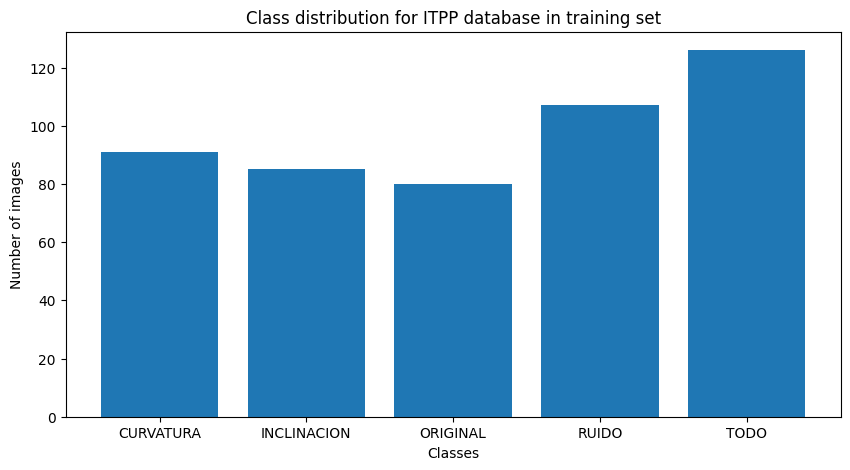

In [ ]:
import matplotlib.pyplot as plt
import os

# Count the number of images in each class in the training directory
class_counts = {}
for class_name in classes[:]:
    class_dir = os.path.join(training_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in training set")
#plt.show()
plt.savefig('training_set_ITPP.pdf', format='pdf')

In [ ]:
class_counts = {}
for class_name in classes[:]:
    class_dir = os.path.join(validation_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in test set")
#plt.show()
plt.savefig('test_set_ITPP.pdf', format='pdf')

NameError: name 'classes' is not defined

# Define dataloader and data transformation via torchvision

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.00255
EPOCHES = 30
THRESHOLD = 0.4

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

class DatasetImageCustom(datasets.DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ):
        super().__init__(
            root,
            loader,
            datasets.folder.IMG_EXTENSIONS,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        # Extract the filename from the path
        path = self.samples[index][0]
        filename = os.path.basename(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, filename

In [ ]:
traindir = "/content/data/training"
testdir = "/content/data/validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                       transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = DatasetImageCustom(traindir,transform=train_transforms)
test_data = DatasetImageCustom(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=BATCH_SIZE)

# Define model and trainer

In [ ]:
class ModelWithSigmoid(nn.Module):
    def __init__(self, model, labels):
        super(ModelWithSigmoid, self).__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()  # Apply softmax along the class dimension

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [ ]:
def predict_with_softmax(model, input_tensor):
    """
    Predicts the class with the highest probability after applying softmax.

    Args:
        model: The PyTorch model.
        input_tensor: The input tensor.

    Returns:
        The predicted class (int) and the probabilities (tensor).
    """
    # Ensure the model is in evaluation mode
    model.eval()
    with torch.no_grad():
        # Move input tensor to the same device as the model
        input_tensor = input_tensor.to(next(model.parameters()).device)

        # Perform the prediction
        output = model(input_tensor)
        predictions = (outputs > 0.5).cpu().numpy().flatten()

        class_names = ["CURVATURA", "INCLINACIÓN", "RUIDO", "ORIGINAL"]
        predicted_classes = [class_names[i] for i, pred in enumerate(predictions) if pred]

        if len(predicted_classes) > 1 and "ORIGINAL" not in predicted_classes:
          predicted_classes = ["TODO"]

        # Return probabilities
        probabilities = output.cpu()

        return predicted_classes

# Model definition

In [ ]:
# Function to count the total number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Include fined labels for todo

In [ ]:
def get_todo_labels(image_sample_name):
    reverse_mapping_classes = ['CURVATURA', 'INCLINACION', 'ORIGINAL', 'RUIDO']
    one_hot_labels = [0, 0, 0 ,0]
    for index, label in enumerate(reverse_mapping_classes):
        if label in image_sample_name:
            one_hot_labels[index] = 1

    return one_hot_labels

In [ ]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y, image_sample_name):
        yhat = model(x)
        #y=y.squeeze(1).to(torch.int64)
        model.train()
        label_one_hot=[]
        for index, label in enumerate(y):
            if label < 4:
                label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
            else:
                encoded_label = get_todo_labels(image_sample_name[index])
                label_one_hot.append(encoded_label) # [1,1,0,1] for all

        label_one_hot = torch.tensor(label_one_hot).to(device)
        loss = loss_fn(yhat,label_one_hot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    return train_step

device = "cuda" if torch.cuda.is_available() else "cpu"
model_base = models.resnet18(pretrained=True)

#freeze all params
#for params in model_base.parameters():
    #params.requires_grad_ = False

#add a new final layer
nr_filters = model_base.fc.in_features  #number of input features of last layer
print("features space out: ", nr_filters)

# Replace the final fully connected layer with a new one
model_base.fc = nn.Linear(nr_filters, 4)

model = ModelWithSigmoid(model_base, 4)#

model = model.to(device)

#loss
loss_fn = nn.BCELoss()

for name, param in model.named_parameters():
    if not any(layer_name in name for layer_name in ['model.fc', 'fc1', 'fc2']):
        param.requires_grad = False
    else:
      print(name, 'is not freeze')

# Count the parameters
total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#train step
train_step = make_train_step(model, optimizer, loss_fn)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


features space out:  512
model.fc.weight is not freeze
model.fc.bias is not freeze
Total parameters: 11178564
Trainable parameters: 2052


# Train model with early stoping

# Load model for continue training

In [ ]:
model_path = "/content/drive/MyDrive/model_weights_model_sigmoid_todo_new.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = EPOCHES
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
        x_batch , y_batch, image_sample_name = data
        x_batch = x_batch.to(device) #move to gpu
        y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu


        loss = train_step(x_batch, y_batch, image_sample_name)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)

    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

    #validation doesnt requires gradient
    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch, image_sample_name in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch)
            #y_batch=y_batch.squeeze(1).to(torch.int64)

            label_one_hot=[]
            for index, label in enumerate(y_batch):
                if label < 4:
                    label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
                else:
                    encoded_label = get_todo_labels(image_sample_name[index])
                    label_one_hot.append(encoded_label) # [1,1,0,1] for all

            label_one_hot = torch.tensor(label_one_hot).to(device)
            val_loss = loss_fn(yhat,label_one_hot)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())


        epoch_test_losses.append(cum_loss)
        print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))

        best_loss = min(epoch_test_losses)

        #save best model
        if cum_loss <= best_loss:
            best_model_wts = model.state_dict()

        #early stopping
        early_stopping_counter = 0
        if cum_loss > best_loss:
            early_stopping_counter +=1

        if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
            print("/nTerminating: early stopping")
            break #terminate training

#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 31/31 [02:00<00:00,  3.89s/it]



Epoch : 1, train loss : 0.6232489347457886
Epoch : 1, val loss : 0.5047517418861389


100%|██████████| 31/31 [01:53<00:00,  3.66s/it]



Epoch : 2, train loss : 0.5677459239959717
Epoch : 2, val loss : 0.49907684326171875


100%|██████████| 31/31 [01:54<00:00,  3.70s/it]



Epoch : 3, train loss : 0.565837562084198
Epoch : 3, val loss : 0.6007230877876282


100%|██████████| 31/31 [01:52<00:00,  3.62s/it]



Epoch : 4, train loss : 0.5521284937858582
Epoch : 4, val loss : 0.5652349591255188


100%|██████████| 31/31 [01:50<00:00,  3.56s/it]



Epoch : 5, train loss : 0.517787754535675
Epoch : 5, val loss : 0.48225468397140503


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 6, train loss : 0.5198029279708862
Epoch : 6, val loss : 0.5152209401130676


100%|██████████| 31/31 [01:49<00:00,  3.53s/it]



Epoch : 7, train loss : 0.4975379407405853
Epoch : 7, val loss : 0.4586639404296875


100%|██████████| 31/31 [01:49<00:00,  3.52s/it]



Epoch : 8, train loss : 0.5094285607337952
Epoch : 8, val loss : 0.43973585963249207


100%|██████████| 31/31 [01:49<00:00,  3.54s/it]



Epoch : 9, train loss : 0.5029657483100891
Epoch : 9, val loss : 0.6682997345924377


100%|██████████| 31/31 [01:44<00:00,  3.38s/it]



Epoch : 10, train loss : 0.503247082233429
Epoch : 10, val loss : 0.4657452702522278


100%|██████████| 31/31 [01:46<00:00,  3.44s/it]



Epoch : 11, train loss : 0.4985705614089966
Epoch : 11, val loss : 0.4926537871360779


100%|██████████| 31/31 [01:46<00:00,  3.42s/it]



Epoch : 12, train loss : 0.5026935935020447
Epoch : 12, val loss : 0.5441027283668518


100%|██████████| 31/31 [01:47<00:00,  3.45s/it]



Epoch : 13, train loss : 0.49856942892074585
Epoch : 13, val loss : 0.6187193393707275


100%|██████████| 31/31 [01:46<00:00,  3.42s/it]



Epoch : 14, train loss : 0.49592453241348267
Epoch : 14, val loss : 0.5937740206718445


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 15, train loss : 0.480610728263855
Epoch : 15, val loss : 0.4930431544780731


100%|██████████| 31/31 [01:43<00:00,  3.35s/it]



Epoch : 16, train loss : 0.4589417278766632
Epoch : 16, val loss : 0.4244305491447449


100%|██████████| 31/31 [01:43<00:00,  3.34s/it]



Epoch : 17, train loss : 0.4606975317001343
Epoch : 17, val loss : 0.4480033218860626


100%|██████████| 31/31 [01:41<00:00,  3.27s/it]



Epoch : 18, train loss : 0.48057734966278076
Epoch : 18, val loss : 0.46609216928482056


100%|██████████| 31/31 [01:43<00:00,  3.35s/it]



Epoch : 19, train loss : 0.4678558111190796
Epoch : 19, val loss : 0.4168112576007843


100%|██████████| 31/31 [01:42<00:00,  3.31s/it]



Epoch : 20, train loss : 0.4519489109516144
Epoch : 20, val loss : 0.46063873171806335


100%|██████████| 31/31 [01:44<00:00,  3.38s/it]



Epoch : 21, train loss : 0.4630563259124756
Epoch : 21, val loss : 0.5430572628974915


100%|██████████| 31/31 [01:45<00:00,  3.39s/it]



Epoch : 22, train loss : 0.4670768976211548
Epoch : 22, val loss : 0.5122881531715393


100%|██████████| 31/31 [01:45<00:00,  3.40s/it]



Epoch : 23, train loss : 0.45934346318244934
Epoch : 23, val loss : 0.4049099087715149


100%|██████████| 31/31 [01:44<00:00,  3.38s/it]



Epoch : 24, train loss : 0.4392780065536499
Epoch : 24, val loss : 0.4374101758003235


100%|██████████| 31/31 [01:46<00:00,  3.44s/it]



Epoch : 25, train loss : 0.44660624861717224
Epoch : 25, val loss : 0.48080629110336304


100%|██████████| 31/31 [01:44<00:00,  3.37s/it]



Epoch : 26, train loss : 0.46786513924598694
Epoch : 26, val loss : 0.5181836485862732


100%|██████████| 31/31 [01:44<00:00,  3.37s/it]



Epoch : 27, train loss : 0.464345782995224
Epoch : 27, val loss : 0.5432260632514954


100%|██████████| 31/31 [01:44<00:00,  3.39s/it]



Epoch : 28, train loss : 0.44599294662475586
Epoch : 28, val loss : 0.3825506865978241


100%|██████████| 31/31 [01:44<00:00,  3.38s/it]



Epoch : 29, train loss : 0.4360549747943878
Epoch : 29, val loss : 0.2991027534008026


100%|██████████| 31/31 [01:45<00:00,  3.41s/it]



Epoch : 30, train loss : 0.4297463893890381
Epoch : 30, val loss : 0.5632227063179016


<All keys matched successfully>

#Model evaluation

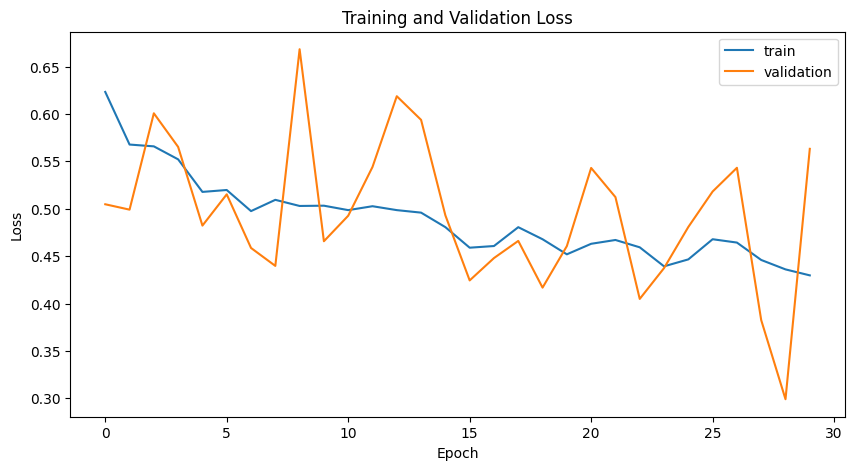

In [ ]:
t_loss=[val.cpu().detach().numpy() for val in epoch_train_losses]
v_loss=[val.cpu().numpy() for val in epoch_test_losses]
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(t_loss, label="train")
plt.plot(v_loss, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def predict_with_thresholds(model, dataloader, device, thresholds):
    """
    Predicts class labels using custom thresholds for each class.

    Args:
        model: The PyTorch model.
        dataloader: The DataLoader for the test data.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        thresholds: A list of thresholds, one for each class.

    Returns:
        A list of predicted labels and a list of true labels.
    """
    y_pred = []
    y_true = []

    todo_performance_analize = []

    with torch.no_grad():
        for x_batch, y_batch, image_sample_name in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()  # Convert target to same nn output shape
            y_batch = y_batch.to(device)
            model.eval()
            yhat = model(x_batch)
            predictions = yhat.cpu().numpy()

            for i in range(predictions.shape[0]):
                predicted_classes = []
                predicted_classes_ponderations = []
                for j in range(predictions.shape[1]):
                    if predictions[i][j] > thresholds[j]:
                        predicted_classes.append(j)
                        predicted_classes_ponderations.append(predictions[i][j])
                if len(predicted_classes) == 0:
                        y_pred.append(2)
                elif len(predicted_classes) == 1:
                    y_pred.append(predicted_classes[0])

                elif len(predicted_classes) > 1 and 2 not in predicted_classes:
                    predicted_classes_ponderations = np.array(predicted_classes_ponderations)
                    score = np.sum(predicted_classes_ponderations)
                    y_pred.append(4)
                else:
                    max_index = np.argmax(predictions[i])
                    y_pred.append(max_index)

            y_true.extend(y_batch.cpu().numpy().flatten())

    return y_pred, y_true, todo_performance_analize

thresholds =  [0.5, 0.5, 0.5, 0.5]#[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

print(classification_report(y_true, y_pred,digits=4, target_names=test_data.classes))

              precision    recall  f1-score   support

   CURVATURA     0.6667    0.5217    0.5854        23
 INCLINACION     0.5000    0.0952    0.1600        21
    ORIGINAL     0.4333    0.6500    0.5200        20
       RUIDO     0.7368    0.5385    0.6222        26
        TODO     0.5000    0.8065    0.6173        31

    accuracy                         0.5455       121
   macro avg     0.5674    0.5224    0.5010       121
weighted avg     0.5716    0.5455    0.5168       121



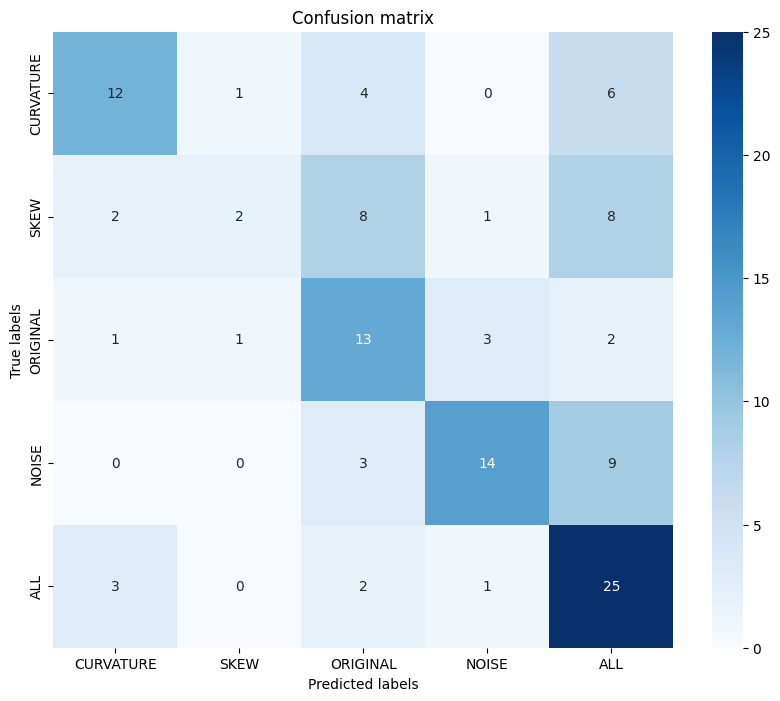

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_resnet18_base_threshold.pdf', format='pdf')

In [ ]:
# prompt: create all measures f1, macro F, roc

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# ... (your existing code) ...

thresholds =  [0.7602731599715904, 0.28838335905834345, 0.3224424159129208, 0.5297425940588911] #[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

# Calculate F1-score (macro average)
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {f1_macro}")

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")

# Classification report
print(classification_report(y_true, y_pred, digits=4, target_names=test_data.classes))


# Calculate ROC AUC score (requires probabilities, not just predictions)
# Binarize the labels for ROC AUC calculation
y_true_binarized = label_binarize(y_true, classes=np.unique(y_pred))

# Assuming your model outputs probabilities
y_prob = []
with torch.no_grad():
    for x_batch, y_batch, image_sample_name in testloader:
        x_batch = x_batch.to(device)
        model.eval()
        yhat = model(x_batch)
        y_prob.extend(yhat.cpu().numpy())
y_prob = np.array(y_prob)

# Calculate ROC AUC for each class
roc_auc_scores = []
n_classes = y_true_binarized.shape[1]
for i in range(4):
    roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
    roc_auc_scores.append(roc_auc)

print(f"ROC AUC scores for each class: {roc_auc_scores}")

# Calculate the macro average of the ROC AUC scores
macro_roc_auc = np.mean(roc_auc_scores)
print(f"Macro-averaged ROC AUC: {macro_roc_auc}")


Macro F1-score: 0.6175754077545792
Macro Precision: 0.6402604802604802
Macro Recall: 0.6209164187845814
              precision    recall  f1-score   support

   CURVATURA     0.8571    0.5217    0.6486        23
 INCLINACION     0.5000    0.5714    0.5333        21
    ORIGINAL     0.5185    0.7000    0.5957        20
       RUIDO     0.6333    0.7308    0.6786        26
        TODO     0.6923    0.5806    0.6316        31

    accuracy                         0.6198       121
   macro avg     0.6403    0.6209    0.6176       121
weighted avg     0.6489    0.6198    0.6219       121

ROC AUC scores for each class: [np.float64(0.5403726708074534), np.float64(0.6021428571428571), np.float64(0.5985148514851485), np.float64(0.5989878542510122)]
Macro-averaged ROC AUC: 0.5850045584216178


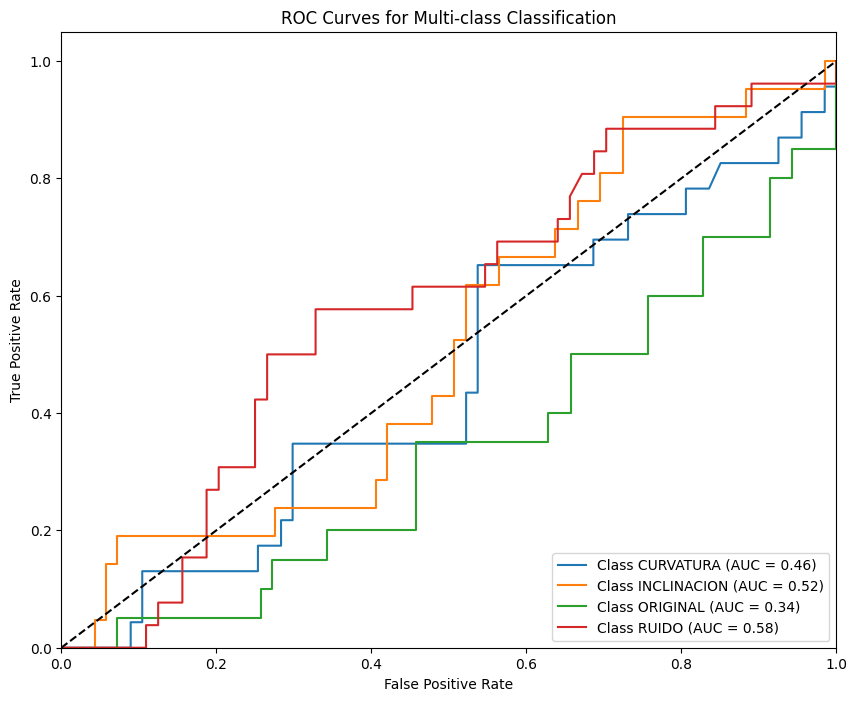

In [ ]:
# prompt: generate chart from ROC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true_binarized and y_prob are defined as in your previous code

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {test_data.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


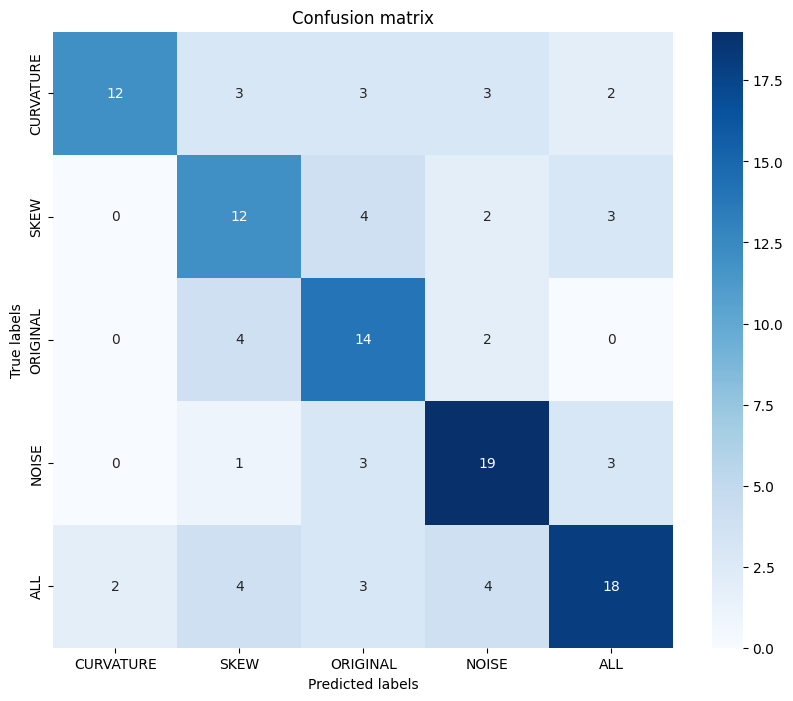

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_resnet18_base_threshold_pso.pdf', format='pdf')

In [ ]:
torch.save(model.state_dict(), 'model_weights_model_sigmoid_todo_new.pth')

#threshold serach via tabu search

# Use PSO for theshold optimization

In [ ]:
import random

def find_best_thresholds(model, dataloader, device, num_particles=20, max_iterations=25, w=0.7, c1=1.4, c2=1.4):
    """
    Finds the best thresholds using Particle Swarm Optimization (PSO).
    """

    num_classes = 4  # Assuming 4 classes
    particles = []
    velocities = []
    for _ in range(num_particles):
      particles.append([random.uniform(0, 1) for _ in range(num_classes)])
      velocities.append([random.uniform(-0.1, 0.1) for _ in range(num_classes)])

    pbest_positions = particles.copy()
    pbest_scores = [0] * num_particles
    gbest_position = particles[0].copy()
    gbest_score = 0


    for iteration in range(max_iterations):
        for i in range(num_particles):
            y_pred, y_true, _ = predict_with_thresholds(model, dataloader, device, particles[i])
            report = classification_report(y_true, y_pred, output_dict=True, digits=4, target_names=test_data.classes)
            f1_score = report['macro avg']['f1-score']

            if f1_score > pbest_scores[i]:
                pbest_scores[i] = f1_score
                pbest_positions[i] = particles[i].copy()

            if f1_score > gbest_score:
                gbest_score = f1_score
                gbest_position = particles[i].copy()

            # Update velocity and position
            for j in range(num_classes):
                r1 = random.random()
                r2 = random.random()
                velocities[i][j] = (w * velocities[i][j] +
                                    c1 * r1 * (pbest_positions[i][j] - particles[i][j]) +
                                    c2 * r2 * (gbest_position[j] - particles[i][j]))
                particles[i][j] = max(0, min(1, particles[i][j] + velocities[i][j]))  # Keep within [0,1]
        print(f"Iteration {iteration + 1}: Best F1 = {gbest_score:.4f}, Thresholds = {gbest_position}")

    return gbest_position

find_best_thresholds(model, testloader, device)

Iteration 1: Best F1 = 0.6157, Thresholds = [0.6651472364405617, 0.16822870280048796, 0.3913993591129741, 0.4339054970911791]
Iteration 2: Best F1 = 0.6442, Thresholds = [0.8241686893417852, 0.3271260986660731, 0.32197502565123826, 0.5143469639752174]
Iteration 3: Best F1 = 0.6481, Thresholds = [0.5816443991305424, 0.2666015782135308, 0.40866849950653505, 0.3383847855466176]
Iteration 4: Best F1 = 0.6481, Thresholds = [0.5816443991305424, 0.2666015782135308, 0.40866849950653505, 0.3383847855466176]
Iteration 5: Best F1 = 0.6481, Thresholds = [0.5816443991305424, 0.2666015782135308, 0.40866849950653505, 0.3383847855466176]
Iteration 6: Best F1 = 0.6481, Thresholds = [0.5816443991305424, 0.2666015782135308, 0.40866849950653505, 0.3383847855466176]
Iteration 7: Best F1 = 0.6562, Thresholds = [0.7669716439063008, 0.2052749278391549, 0.18759457144675323, 0.5270148034187729]
Iteration 8: Best F1 = 0.6562, Thresholds = [0.7669716439063008, 0.2052749278391549, 0.18759457144675323, 0.5270148034

KeyboardInterrupt: 

              precision    recall  f1-score   support

   CURVATURA     0.8571    0.5217    0.6486        23
 INCLINACION     0.5000    0.5714    0.5333        21
    ORIGINAL     0.5185    0.7000    0.5957        20
       RUIDO     0.6333    0.7308    0.6786        26
        TODO     0.6923    0.5806    0.6316        31

    accuracy                         0.6198       121
   macro avg     0.6403    0.6209    0.6176       121
weighted avg     0.6489    0.6198    0.6219       121



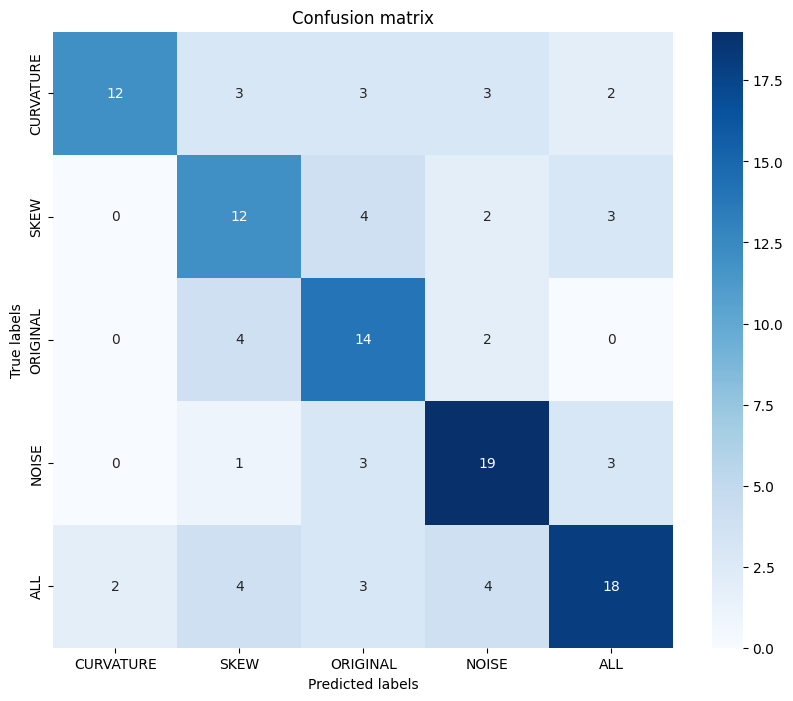

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
thresholds =  [0.7602731599715904, 0.28838335905834345, 0.3224424159129208, 0.5297425940588911]#[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

# Classification report
print(classification_report(y_true, y_pred, digits=4, target_names=test_data.classes))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_resnet18_base_threshold_pso.pdf', format='pdf')

# Genetic algorithms

In [ ]:
import random

def fitness_function(thresholds, model, dataloader, device):
    """Calculates the fitness (macro F1-score) for given thresholds."""
    y_pred, y_true, _ = predict_with_thresholds(model, dataloader, device, thresholds)
    report = classification_report(y_true, y_pred, output_dict=True, digits=4, target_names=test_data.classes)
    return report['macro avg']['f1-score']

def genetic_algorithm(model, dataloader, device, population_size=25, generations=25, mutation_rate=0.1):
    """
    Optimizes thresholds using a genetic algorithm.
    """

    num_classes = 4  # Number of classes
    # Initialize the population with random thresholds
    population = [[random.uniform(0, 1) for _ in range(num_classes)] for _ in range(population_size)]

    best_thresholds = None
    best_fitness = 0

    for generation in range(generations):
        fitness_scores = [fitness_function(thresholds, model, dataloader, device) for thresholds in population]

        # Find the best individual in the current generation
        current_best_index = fitness_scores.index(max(fitness_scores))
        current_best_fitness = fitness_scores[current_best_index]
        current_best_thresholds = population[current_best_index]

        if current_best_fitness > best_fitness:
          best_fitness = current_best_fitness
          best_thresholds = current_best_thresholds

        # Select parents using tournament selection
        parents = []
        for _ in range(population_size):
            tournament = random.sample(range(population_size), 5)  # Tournament size 5
            winner = tournament[0]
            for i in tournament[1:]:
                if fitness_scores[i] > fitness_scores[winner]:
                    winner = i
            parents.append(population[winner])

        # Create the next generation through crossover and mutation
        new_population = []
        for i in range(0, population_size, 2):
            parent1 = parents[i]
            parent2 = parents[i + 1]

            # Crossover
            crossover_point = random.randint(1, num_classes-1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]

            # Mutation
            for j in range(num_classes):
                if random.random() < mutation_rate:
                    child1[j] = max(0, min(1, child1[j] + random.uniform(-0.1, 0.1))) # Keep within [0, 1]
                if random.random() < mutation_rate:
                    child2[j] = max(0, min(1, child2[j] + random.uniform(-0.1, 0.1))) # Keep within [0, 1]

            new_population.extend([child1, child2])

        population = new_population
        print(f"Generation {generation + 1}: Best F1 = {best_fitness:.4f}, Thresholds = {best_thresholds}")

    return best_thresholds

best_thresholds_ga = genetic_algorithm(model, testloader, device)
print(f"\nBest thresholds found by genetic algorithm: {best_thresholds_ga}")


# Bacterial foraging optimization

In [ ]:
# prompt: Use bacterial foraging optimization for threshold estimation
def bacterial_foraging_optimization(model, dataloader, device, num_bacteria=20, num_iterations=25, Nc=5, Ns=4, Ned=2, C_attr=0.1, p_eliminate=0.2):
    """
    Finds the best thresholds using Bacterial Foraging Optimization (BFO).
    """
    num_classes = 4
    bacteria = []
    for _ in range(num_bacteria):
      bacteria.append([random.uniform(0, 1) for _ in range(num_classes)])

    best_thresholds = None
    best_fitness = 0

    for iteration in range(num_iterations):
        # 1. Chemotaxis
        for b in range(num_bacteria):
            for _ in range(Nc):
              delta = [random.uniform(-0.1, 0.1) for _ in range(num_classes)]
              new_thresholds = [max(0, min(1, t + d)) for t,d in zip(bacteria[b],delta)]

              y_pred, y_true, _ = predict_with_thresholds(model, dataloader, device, new_thresholds)
              report = classification_report(y_true, y_pred, output_dict=True, digits=4, target_names=test_data.classes)
              new_fitness = report['macro avg']['f1-score']

              if new_fitness > fitness_function(bacteria[b], model, dataloader, device):
                 bacteria[b] = new_thresholds

        # 2. Reproduction
        fitness_scores = [fitness_function(thresholds, model, dataloader, device) for thresholds in bacteria]
        sorted_bacteria = sorted(zip(bacteria, fitness_scores), key=lambda x: x[1], reverse=True)
        bacteria = [b for b, f in sorted_bacteria]
        bacteria = bacteria[:num_bacteria//2] + bacteria[:num_bacteria//2] # Duplicate the top half

        # 3. Elimination and Dispersal
        for i in range(num_bacteria):
            if random.random() < p_eliminate:
                bacteria[i] = [random.uniform(0, 1) for _ in range(num_classes)]

        # Check for the best solution in the current iteration
        current_best_index = np.argmax([fitness_function(thresholds, model, dataloader, device) for thresholds in bacteria])
        current_best_fitness = fitness_function(bacteria[current_best_index], model, dataloader, device)
        current_best_thresholds = bacteria[current_best_index]

        if current_best_fitness > best_fitness:
          best_fitness = current_best_fitness
          best_thresholds = current_best_thresholds

        print(f"Iteration {iteration + 1}: Best F1 = {best_fitness:.4f}, Thresholds = {best_thresholds}")

    return best_thresholds
best_thresholds_bfo = bacterial_foraging_optimization(model, testloader, device)
print(f"\nBest thresholds found by bacterial foraging optimization: {best_thresholds_bfo}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

KeyboardInterrupt: 

# Use Firefly algorithms

In [ ]:
# prompt: Use Firefly algorithms

import random

# ... (your existing code) ...

def firefly_algorithm(model, dataloader, device, num_fireflies=20, max_iterations=25, absorption_coefficient=0.1, attractiveness=1.0):
    """
    Finds the best thresholds using the Firefly Algorithm.
    """
    num_classes = 4
    fireflies = []
    for _ in range(num_fireflies):
        fireflies.append([random.uniform(0, 1) for _ in range(num_classes)])

    best_thresholds = None
    best_fitness = 0

    for iteration in range(max_iterations):
        for i in range(num_fireflies):
            for j in range(num_fireflies):
                if fitness_function(fireflies[j], model, dataloader, device) > fitness_function(fireflies[i], model, dataloader, device):
                    # Move firefly i towards firefly j
                    distance = sum([(fireflies[i][k] - fireflies[j][k])**2 for k in range(num_classes)])**0.5
                    beta = attractiveness / (1 + absorption_coefficient * distance)
                    for k in range(num_classes):
                        fireflies[i][k] = fireflies[i][k] + beta * (fireflies[j][k] - fireflies[i][k]) + random.uniform(-0.1, 0.1)
                        fireflies[i][k] = max(0, min(1, fireflies[i][k]))  # Keep within [0, 1]


            current_fitness = fitness_function(fireflies[i], model, dataloader, device)
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_thresholds = fireflies[i]

        print(f"Iteration {iteration + 1}: Best F1 = {best_fitness:.4f}, Thresholds = {best_thresholds}")

    return best_thresholds

best_thresholds_fa = firefly_algorithm(model, testloader, device)
print(f"\nBest thresholds found by firefly algorithm: {best_thresholds_fa}")
